In [6]:
# Required Packages
#!pip install shap
#!pip install optuna
#!pip install xgboost

In [7]:
# Model Packages
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from optuna.visualization.matplotlib import plot_param_importances
import optuna
from lightgbm import LGBMRegressor
import xgboost
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

# Standard Packages
import shap
import pandas as pd
import missingno as mnso
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import warnings
from typing import Iterable
import re

# model importing
import joblib
import pickle

# Warning
warnings.filterwarnings('ignore')

# To export graphs
%matplotlib inline

In [8]:
train = pd.read_csv("/kaggle/input/bike-sharing-demand-dataset/hour.csv")

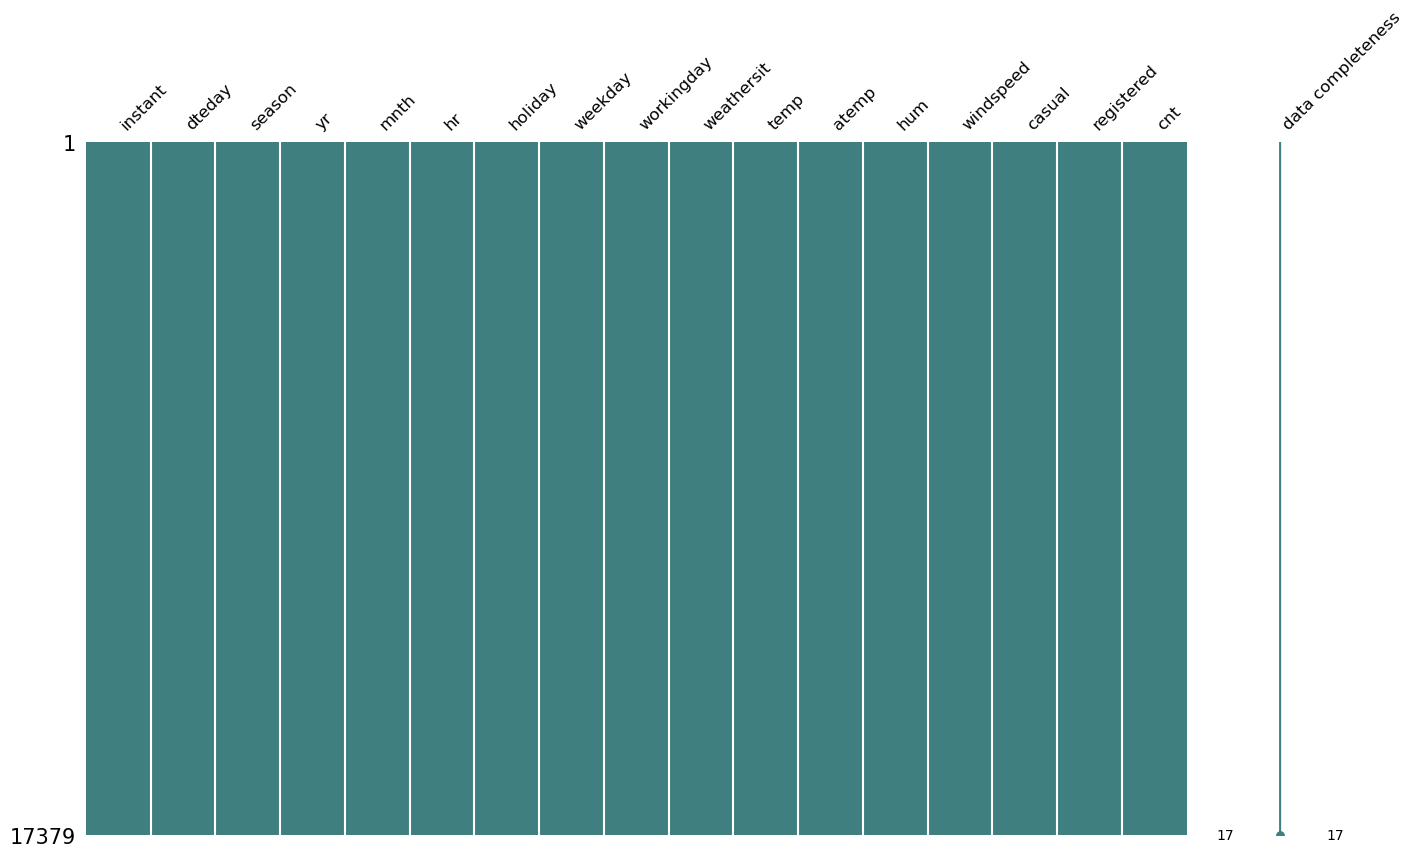

In [9]:
mnso.matrix(train,labels=17,figsize=(16,9),fontsize=12,width_ratios=(12,1), color=(0.25,0.5,0.5));plt.show()

In [10]:
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [16]:
X = train.drop(["cnt","registered","casual"], axis=1)
y = train["cnt"]

In [38]:
hyperparameters_lgb = {
    
    "n_estimators":[200,2000],
    "learning_rate":[0.01,0.5],
    "num_leaves":[20,500],
    "max_depth":[3,12],
    "min_data_in_leaf":[200,10000],
    "max_bin":[200,300],
    "lambda_l1":[0,100],
    "lambda_l2":[0,200],
    "min_gain_to_split":[0,15]
}


hyperparameters_xgb = {
    
    "max_depth": [1, 17],
    "learning_rate": [0.01, 0.15],
    "n_estimators": [50, 1500],
    "subsample": [0.01, 0.65],
    "colsample_bytree": [0.01, 0.95],
    "reg_alpha": [0.1, 0.5],
    "reg_lambda": [0.1, 0.5]
}

In [33]:
class BuildRegressionModel:
    
    """ build a baseline ml model based on linear regression """
    
    def __init__(self, X, y):
        
        self.X = X
        self.y = y
    
    def shuffle_data(self, shuffle=True, test_size=30):
                
        self.shuffle=shuffle
        self.test_size=test_size
        
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, 
                                                            shuffle=self.shuffle,
                                                            test_size=self.test_size, 
                                                            random_state=42)      
        return X_train, X_test, y_train, y_test
        
    def baseline_lr(self, X_train, y_train, X_test):
    
        # instantiate lr model
        model = LinearRegression()
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return y_pred, model
    
    def lgb_obj(trial, hyperparameters=hyperparameters_lgb):

        param = {}

        for key, value in hyperparameters.items():
            if isinstance(value, Iterable):
                if isinstance(value[0], float):
                    param[key] = trial.suggest_float(key, value[0], value[1])
                else:
                    param[key] = trial.suggest_int(key, value[0], value[1])
            else:
                param[key] = value

        # non-hyperparameter settings
        param["n_jobs"] = -1 # deploy 100% of gpu's computational power 
        param["random_state"] = 42
        

        model = LGBMRegressor(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return (mean_squared_error(y_test, y_pred))**(1/2)
    
    
    def xgb_obj(trial, hyperparameters=hyperparameters_xgb):
        param = {}

        for key, value in hyperparameters.items():
            if isinstance(value, Iterable):
                if isinstance(value[0], float):
                    param[key] = trial.suggest_float(key, value[0], value[1])
                else:
                    param[key] = trial.suggest_int(key, value[0], value[1])
            else:
                param[key] = value

        # non-hyperparameter settings
        param["n_jobs"] = -1 # deploy 100% of gpu's computational power 
        param["random_state"] = 42

        model = xgboost.XGBRegressor(**param)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        return (mean_squared_error(y_test, y_pred))**(1/2)
    
    def get_regression_result(self, y_test, y_pred):
        
        self.y_test = y_test
        self.y_pred = y_pred
        
        rmse = MSE(y_test, y_pred)**1/2
        
        return print("r^2: {:.3f}".format(r2_score(y_test, y_pred)))        

In [34]:
# instantiate modeller
brm = BuildRegressionModel(X,y)

# shuffle and split data
X_train, X_test, y_train, y_test = brm.shuffle_data()

In [29]:
# Fit_predict baseline linear regression
y_pred, model = brm.baseline_lr(X_train, y_train, X_test)

# Baseline Linear Regression results
brm.get_regression_result(y_test, y_pred)

r^2: 0.455


**ExtremeGradientBoosting**

In [22]:
study_xgb = optuna.create_study(direction='minimize',study_name='XGBregression')
study_xgb.optimize(BuildRegressionModel.xgb_obj, n_trials=100)

model_xgb = xgboost.XGBRegressor(**study_xgb.best_params)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

[I 2023-04-17 14:27:25,594] A new study created in memory with name: XGBregression
[I 2023-04-17 14:27:30,716] Trial 0 finished with value: 49.217018630765835 and parameters: {'max_depth': 15, 'learning_rate': 0.09195073914991636, 'n_estimators': 90, 'subsample': 0.14088908765116295, 'colsample_bytree': 0.8438732791117262, 'reg_alpha': 0.3234288223856379, 'reg_lambda': 0.2997545207077147}. Best is trial 0 with value: 49.217018630765835.
[I 2023-04-17 14:27:35,777] Trial 1 finished with value: 113.47026679454608 and parameters: {'max_depth': 7, 'learning_rate': 0.10465202246796644, 'n_estimators': 820, 'subsample': 0.45618573198909484, 'colsample_bytree': 0.17374299079774727, 'reg_alpha': 0.46608286426588197, 'reg_lambda': 0.2783637732503288}. Best is trial 0 with value: 49.217018630765835.
[I 2023-04-17 14:27:43,181] Trial 2 finished with value: 62.35999344521757 and parameters: {'max_depth': 4, 'learning_rate': 0.14523788290598103, 'n_estimators': 1198, 'subsample': 0.0986782788443168

In [30]:
# Optimized XGBoosting Model Results
brm.get_regression_result(y_test, y_pred_xgb)

r^2: 0.969


In [31]:
# XGBM hyperparameter importance
optuna.visualization.plot_param_importances(study_xgb)

In [24]:
# XGBM hyperparameter importance
optuna.visualization.plot_slice(study_xgb)

**LightGradientBoosting**

In [39]:
study_lgb = optuna.create_study(direction='minimize',study_name='LGBRegression')
study_lgb.optimize(BuildRegressionModel.lgb_obj, n_trials=100)

modellgb = LGBMRegressor(**study_lgb.best_params)
modellgb.fit(X_train, y_train)
y_pred_lgb = modellgb.predict(X_test)

[I 2023-04-17 15:14:05,287] A new study created in memory with name: LGBRegression


[LightGBM] [Warning] lambda_l1 is set=81, reg_alpha=0.0 will be ignored. Current value: lambda_l1=81
[LightGBM] [Warning] min_data_in_leaf is set=457, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=457
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8
[LightGBM] [Warning] lambda_l2 is set=68, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68


[I 2023-04-17 15:14:07,414] Trial 0 finished with value: 57.93874803853815 and parameters: {'n_estimators': 356, 'learning_rate': 0.03897939863943088, 'num_leaves': 292, 'max_depth': 12, 'min_data_in_leaf': 457, 'max_bin': 206, 'lambda_l1': 81, 'lambda_l2': 68, 'min_gain_to_split': 8}. Best is trial 0 with value: 57.93874803853815.


[LightGBM] [Warning] lambda_l1 is set=69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=69
[LightGBM] [Warning] min_data_in_leaf is set=406, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=406
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=72, reg_lambda=0.0 will be ignored. Current value: lambda_l2=72


[I 2023-04-17 15:14:08,998] Trial 1 finished with value: 51.45522866086424 and parameters: {'n_estimators': 510, 'learning_rate': 0.20423470560905166, 'num_leaves': 149, 'max_depth': 5, 'min_data_in_leaf': 406, 'max_bin': 245, 'lambda_l1': 69, 'lambda_l2': 72, 'min_gain_to_split': 12}. Best is trial 1 with value: 51.45522866086424.


[LightGBM] [Warning] lambda_l1 is set=75, reg_alpha=0.0 will be ignored. Current value: lambda_l1=75
[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


[I 2023-04-17 15:14:15,878] Trial 2 finished with value: 49.1607899962092 and parameters: {'n_estimators': 983, 'learning_rate': 0.1547878654422179, 'num_leaves': 198, 'max_depth': 11, 'min_data_in_leaf': 281, 'max_bin': 221, 'lambda_l1': 75, 'lambda_l2': 70, 'min_gain_to_split': 1}. Best is trial 2 with value: 49.1607899962092.


[LightGBM] [Warning] lambda_l1 is set=62, reg_alpha=0.0 will be ignored. Current value: lambda_l1=62
[LightGBM] [Warning] min_data_in_leaf is set=348, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=348
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18


[I 2023-04-17 15:14:17,445] Trial 3 finished with value: 53.22812869810733 and parameters: {'n_estimators': 551, 'learning_rate': 0.23280025346437402, 'num_leaves': 113, 'max_depth': 5, 'min_data_in_leaf': 348, 'max_bin': 231, 'lambda_l1': 62, 'lambda_l2': 18, 'min_gain_to_split': 7}. Best is trial 2 with value: 49.1607899962092.


[LightGBM] [Warning] lambda_l1 is set=19, reg_alpha=0.0 will be ignored. Current value: lambda_l1=19
[LightGBM] [Warning] min_data_in_leaf is set=332, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=332
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l2 is set=92, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92


[I 2023-04-17 15:14:23,878] Trial 4 finished with value: 45.71976866494563 and parameters: {'n_estimators': 930, 'learning_rate': 0.21139350799874826, 'num_leaves': 181, 'max_depth': 12, 'min_data_in_leaf': 332, 'max_bin': 202, 'lambda_l1': 19, 'lambda_l2': 92, 'min_gain_to_split': 0}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=73, reg_alpha=0.0 will be ignored. Current value: lambda_l1=73
[LightGBM] [Warning] min_data_in_leaf is set=396, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=396
[LightGBM] [Warning] min_gain_to_split is set=6, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1


[I 2023-04-17 15:14:25,257] Trial 5 finished with value: 54.60731875951356 and parameters: {'n_estimators': 386, 'learning_rate': 0.1399184990434353, 'num_leaves': 293, 'max_depth': 6, 'min_data_in_leaf': 396, 'max_bin': 221, 'lambda_l1': 73, 'lambda_l2': 1, 'min_gain_to_split': 6}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=86, reg_alpha=0.0 will be ignored. Current value: lambda_l1=86
[LightGBM] [Warning] min_data_in_leaf is set=464, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=464
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=33, reg_lambda=0.0 will be ignored. Current value: lambda_l2=33


[I 2023-04-17 15:14:29,774] Trial 6 finished with value: 47.04243715292965 and parameters: {'n_estimators': 902, 'learning_rate': 0.17419195102986165, 'num_leaves': 294, 'max_depth': 11, 'min_data_in_leaf': 464, 'max_bin': 280, 'lambda_l1': 86, 'lambda_l2': 33, 'min_gain_to_split': 12}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=24, reg_alpha=0.0 will be ignored. Current value: lambda_l1=24
[LightGBM] [Warning] min_data_in_leaf is set=876, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=876
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


[I 2023-04-17 15:14:31,982] Trial 7 finished with value: 58.150125993707114 and parameters: {'n_estimators': 725, 'learning_rate': 0.2442150344463178, 'num_leaves': 198, 'max_depth': 7, 'min_data_in_leaf': 876, 'max_bin': 262, 'lambda_l1': 24, 'lambda_l2': 3, 'min_gain_to_split': 13}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] min_data_in_leaf is set=356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=356
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] lambda_l2 is set=62, reg_lambda=0.0 will be ignored. Current value: lambda_l2=62


[I 2023-04-17 15:14:33,402] Trial 8 finished with value: 53.82738213656766 and parameters: {'n_estimators': 515, 'learning_rate': 0.15019282858342448, 'num_leaves': 226, 'max_depth': 5, 'min_data_in_leaf': 356, 'max_bin': 267, 'lambda_l1': 8, 'lambda_l2': 62, 'min_gain_to_split': 4}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=31, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31
[LightGBM] [Warning] min_data_in_leaf is set=840, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=840
[LightGBM] [Warning] min_gain_to_split is set=7, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=7
[LightGBM] [Warning] lambda_l2 is set=28, reg_lambda=0.0 will be ignored. Current value: lambda_l2=28


[I 2023-04-17 15:14:35,028] Trial 9 finished with value: 56.77889453950905 and parameters: {'n_estimators': 780, 'learning_rate': 0.29742600986405715, 'num_leaves': 116, 'max_depth': 4, 'min_data_in_leaf': 840, 'max_bin': 249, 'lambda_l1': 31, 'lambda_l2': 28, 'min_gain_to_split': 7}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=43, reg_alpha=0.0 will be ignored. Current value: lambda_l1=43
[LightGBM] [Warning] min_data_in_leaf is set=651, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=651
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l2 is set=98, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98


[I 2023-04-17 15:14:38,031] Trial 10 finished with value: 52.798253480844274 and parameters: {'n_estimators': 745, 'learning_rate': 0.09264477714849254, 'num_leaves': 35, 'max_depth': 9, 'min_data_in_leaf': 651, 'max_bin': 299, 'lambda_l1': 43, 'lambda_l2': 98, 'min_gain_to_split': 0}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=591, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=591
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l2 is set=41, reg_lambda=0.0 will be ignored. Current value: lambda_l2=41


[I 2023-04-17 15:14:42,130] Trial 11 finished with value: 49.38611664202778 and parameters: {'n_estimators': 972, 'learning_rate': 0.20159824515432043, 'num_leaves': 245, 'max_depth': 10, 'min_data_in_leaf': 591, 'max_bin': 290, 'lambda_l1': 100, 'lambda_l2': 41, 'min_gain_to_split': 11}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] min_data_in_leaf is set=575, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=575
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l2 is set=45, reg_lambda=0.0 will be ignored. Current value: lambda_l2=45


[I 2023-04-17 15:14:45,995] Trial 12 finished with value: 49.50066945723342 and parameters: {'n_estimators': 883, 'learning_rate': 0.10818755456631111, 'num_leaves': 43, 'max_depth': 12, 'min_data_in_leaf': 575, 'max_bin': 280, 'lambda_l1': 0, 'lambda_l2': 45, 'min_gain_to_split': 10}. Best is trial 4 with value: 45.71976866494563.


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=210, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=210
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=94, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94


[I 2023-04-17 15:14:51,192] Trial 13 finished with value: 41.15166527324214 and parameters: {'n_estimators': 862, 'learning_rate': 0.19589135620654693, 'num_leaves': 250, 'max_depth': 9, 'min_data_in_leaf': 210, 'max_bin': 202, 'lambda_l1': 100, 'lambda_l2': 94, 'min_gain_to_split': 15}. Best is trial 13 with value: 41.15166527324214.


[LightGBM] [Warning] lambda_l1 is set=48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=48
[LightGBM] [Warning] min_data_in_leaf is set=286, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=286
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=99, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99


[I 2023-04-17 15:14:55,677] Trial 14 finished with value: 43.89631285487168 and parameters: {'n_estimators': 834, 'learning_rate': 0.2611524172730225, 'num_leaves': 248, 'max_depth': 8, 'min_data_in_leaf': 286, 'max_bin': 201, 'lambda_l1': 48, 'lambda_l2': 99, 'min_gain_to_split': 15}. Best is trial 13 with value: 41.15166527324214.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] min_data_in_leaf is set=212, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=212
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


[I 2023-04-17 15:14:59,784] Trial 15 finished with value: 40.397171871770034 and parameters: {'n_estimators': 660, 'learning_rate': 0.27502254558819167, 'num_leaves': 247, 'max_depth': 8, 'min_data_in_leaf': 212, 'max_bin': 212, 'lambda_l1': 45, 'lambda_l2': 85, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=59, reg_alpha=0.0 will be ignored. Current value: lambda_l1=59
[LightGBM] [Warning] min_data_in_leaf is set=227, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=227
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=86, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86


[I 2023-04-17 15:15:03,684] Trial 16 finished with value: 44.4604726151889 and parameters: {'n_estimators': 638, 'learning_rate': 0.295920239604673, 'num_leaves': 255, 'max_depth': 8, 'min_data_in_leaf': 227, 'max_bin': 222, 'lambda_l1': 59, 'lambda_l2': 86, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=38, reg_alpha=0.0 will be ignored. Current value: lambda_l1=38
[LightGBM] [Warning] min_data_in_leaf is set=203, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=203
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=82, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82


[I 2023-04-17 15:15:05,105] Trial 17 finished with value: 50.65809402710774 and parameters: {'n_estimators': 205, 'learning_rate': 0.2712606240729354, 'num_leaves': 151, 'max_depth': 9, 'min_data_in_leaf': 203, 'max_bin': 236, 'lambda_l1': 38, 'lambda_l2': 82, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=98, reg_alpha=0.0 will be ignored. Current value: lambda_l1=98
[LightGBM] [Warning] min_data_in_leaf is set=744, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=744
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


[I 2023-04-17 15:15:07,288] Trial 18 finished with value: 58.57596464052589 and parameters: {'n_estimators': 651, 'learning_rate': 0.2349173322767436, 'num_leaves': 265, 'max_depth': 7, 'min_data_in_leaf': 744, 'max_bin': 214, 'lambda_l1': 98, 'lambda_l2': 80, 'min_gain_to_split': 9}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=54, reg_alpha=0.0 will be ignored. Current value: lambda_l1=54
[LightGBM] [Warning] min_data_in_leaf is set=984, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=984
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=54, reg_lambda=0.0 will be ignored. Current value: lambda_l2=54


[I 2023-04-17 15:15:08,399] Trial 19 finished with value: 63.06210523908977 and parameters: {'n_estimators': 681, 'learning_rate': 0.27272204231523905, 'num_leaves': 217, 'max_depth': 3, 'min_data_in_leaf': 984, 'max_bin': 213, 'lambda_l1': 54, 'lambda_l2': 54, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=91, reg_alpha=0.0 will be ignored. Current value: lambda_l1=91
[LightGBM] [Warning] min_data_in_leaf is set=487, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=487
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l2 is set=56, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56


[I 2023-04-17 15:15:12,153] Trial 20 finished with value: 46.51171420734833 and parameters: {'n_estimators': 821, 'learning_rate': 0.18759160504305156, 'num_leaves': 115, 'max_depth': 9, 'min_data_in_leaf': 487, 'max_bin': 233, 'lambda_l1': 91, 'lambda_l2': 56, 'min_gain_to_split': 3}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=47, reg_alpha=0.0 will be ignored. Current value: lambda_l1=47
[LightGBM] [Warning] min_data_in_leaf is set=269, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=269
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


[I 2023-04-17 15:15:16,459] Trial 21 finished with value: 43.65180448370021 and parameters: {'n_estimators': 835, 'learning_rate': 0.26058502234353287, 'num_leaves': 262, 'max_depth': 8, 'min_data_in_leaf': 269, 'max_bin': 201, 'lambda_l1': 47, 'lambda_l2': 100, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=204, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=204
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


[I 2023-04-17 15:15:23,557] Trial 22 finished with value: 45.853056109640406 and parameters: {'n_estimators': 833, 'learning_rate': 0.22504296770179638, 'num_leaves': 271, 'max_depth': 10, 'min_data_in_leaf': 204, 'max_bin': 211, 'lambda_l1': 35, 'lambda_l2': 90, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=48, reg_alpha=0.0 will be ignored. Current value: lambda_l1=48
[LightGBM] [Warning] min_data_in_leaf is set=270, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=270
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=99, reg_lambda=0.0 will be ignored. Current value: lambda_l2=99


[I 2023-04-17 15:15:27,479] Trial 23 finished with value: 41.983930437967416 and parameters: {'n_estimators': 756, 'learning_rate': 0.248609228968829, 'num_leaves': 223, 'max_depth': 8, 'min_data_in_leaf': 270, 'max_bin': 202, 'lambda_l1': 48, 'lambda_l2': 99, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=64, reg_alpha=0.0 will be ignored. Current value: lambda_l1=64
[LightGBM] [Warning] min_data_in_leaf is set=282, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=282
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=78, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78


[I 2023-04-17 15:15:30,069] Trial 24 finished with value: 42.79710246166867 and parameters: {'n_estimators': 589, 'learning_rate': 0.24993836600459585, 'num_leaves': 226, 'max_depth': 7, 'min_data_in_leaf': 282, 'max_bin': 210, 'lambda_l1': 64, 'lambda_l2': 78, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=52, reg_alpha=0.0 will be ignored. Current value: lambda_l1=52
[LightGBM] [Warning] min_data_in_leaf is set=205, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=205
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l2 is set=91, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91


[I 2023-04-17 15:15:35,555] Trial 25 finished with value: 50.562310873326446 and parameters: {'n_estimators': 708, 'learning_rate': 0.22046141014942894, 'num_leaves': 173, 'max_depth': 10, 'min_data_in_leaf': 205, 'max_bin': 227, 'lambda_l1': 52, 'lambda_l2': 91, 'min_gain_to_split': 11}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=26, reg_alpha=0.0 will be ignored. Current value: lambda_l1=26
[LightGBM] [Warning] min_data_in_leaf is set=525, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=525
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=78, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78


[I 2023-04-17 15:15:38,117] Trial 26 finished with value: 43.97333300832538 and parameters: {'n_estimators': 768, 'learning_rate': 0.27968678957751364, 'num_leaves': 205, 'max_depth': 6, 'min_data_in_leaf': 525, 'max_bin': 239, 'lambda_l1': 26, 'lambda_l2': 78, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=42, reg_alpha=0.0 will be ignored. Current value: lambda_l1=42
[LightGBM] [Warning] min_data_in_leaf is set=408, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=408
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=92, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92


[I 2023-04-17 15:15:41,517] Trial 27 finished with value: 47.02286801058775 and parameters: {'n_estimators': 649, 'learning_rate': 0.2461305589465821, 'num_leaves': 235, 'max_depth': 9, 'min_data_in_leaf': 408, 'max_bin': 215, 'lambda_l1': 42, 'lambda_l2': 92, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=57, reg_alpha=0.0 will be ignored. Current value: lambda_l1=57
[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l2 is set=86, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86


[I 2023-04-17 15:15:43,765] Trial 28 finished with value: 50.90123142150476 and parameters: {'n_estimators': 441, 'learning_rate': 0.18808480707874786, 'num_leaves': 282, 'max_depth': 8, 'min_data_in_leaf': 320, 'max_bin': 206, 'lambda_l1': 57, 'lambda_l2': 86, 'min_gain_to_split': 11}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=81, reg_alpha=0.0 will be ignored. Current value: lambda_l1=81
[LightGBM] [Warning] min_data_in_leaf is set=261, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=261
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=64, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64


[I 2023-04-17 15:15:44,626] Trial 29 finished with value: 56.740846365374516 and parameters: {'n_estimators': 216, 'learning_rate': 0.2204457362360252, 'num_leaves': 182, 'max_depth': 6, 'min_data_in_leaf': 261, 'max_bin': 207, 'lambda_l1': 81, 'lambda_l2': 64, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current value: lambda_l1=11
[LightGBM] [Warning] min_data_in_leaf is set=677, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=677
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l2 is set=74, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74


[I 2023-04-17 15:15:47,176] Trial 30 finished with value: 55.352592058329115 and parameters: {'n_estimators': 612, 'learning_rate': 0.2839552889492942, 'num_leaves': 276, 'max_depth': 11, 'min_data_in_leaf': 677, 'max_bin': 258, 'lambda_l1': 11, 'lambda_l2': 74, 'min_gain_to_split': 9}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=64, reg_alpha=0.0 will be ignored. Current value: lambda_l1=64
[LightGBM] [Warning] min_data_in_leaf is set=254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=254
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=82, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82


[I 2023-04-17 15:15:49,775] Trial 31 finished with value: 43.29479752244947 and parameters: {'n_estimators': 566, 'learning_rate': 0.2480664397722477, 'num_leaves': 228, 'max_depth': 7, 'min_data_in_leaf': 254, 'max_bin': 210, 'lambda_l1': 64, 'lambda_l2': 82, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=67, reg_alpha=0.0 will be ignored. Current value: lambda_l1=67
[LightGBM] [Warning] min_data_in_leaf is set=395, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=395
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


[I 2023-04-17 15:15:51,740] Trial 32 finished with value: 50.65591015396583 and parameters: {'n_estimators': 478, 'learning_rate': 0.25899043470722233, 'num_leaves': 213, 'max_depth': 7, 'min_data_in_leaf': 395, 'max_bin': 219, 'lambda_l1': 67, 'lambda_l2': 95, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=81, reg_alpha=0.0 will be ignored. Current value: lambda_l1=81
[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=76, reg_lambda=0.0 will be ignored. Current value: lambda_l2=76


[I 2023-04-17 15:15:55,730] Trial 33 finished with value: 44.460033376557604 and parameters: {'n_estimators': 591, 'learning_rate': 0.24765049882159662, 'num_leaves': 235, 'max_depth': 8, 'min_data_in_leaf': 310, 'max_bin': 200, 'lambda_l1': 81, 'lambda_l2': 76, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=69
[LightGBM] [Warning] min_data_in_leaf is set=377, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=377
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=67, reg_lambda=0.0 will be ignored. Current value: lambda_l2=67


[I 2023-04-17 15:15:59,182] Trial 34 finished with value: 51.95363065097732 and parameters: {'n_estimators': 681, 'learning_rate': 0.2310791743123697, 'num_leaves': 244, 'max_depth': 9, 'min_data_in_leaf': 377, 'max_bin': 225, 'lambda_l1': 69, 'lambda_l2': 67, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=34, reg_alpha=0.0 will be ignored. Current value: lambda_l1=34
[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=86, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86


[I 2023-04-17 15:16:02,026] Trial 35 finished with value: 44.40578489766155 and parameters: {'n_estimators': 796, 'learning_rate': 0.20689951595001368, 'num_leaves': 193, 'max_depth': 6, 'min_data_in_leaf': 300, 'max_bin': 206, 'lambda_l1': 34, 'lambda_l2': 86, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=44, reg_alpha=0.0 will be ignored. Current value: lambda_l1=44
[LightGBM] [Warning] min_data_in_leaf is set=433, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=433
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l2 is set=71, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71


[I 2023-04-17 15:16:04,805] Trial 36 finished with value: 54.53741764941817 and parameters: {'n_estimators': 524, 'learning_rate': 0.2858465165104219, 'num_leaves': 140, 'max_depth': 10, 'min_data_in_leaf': 433, 'max_bin': 216, 'lambda_l1': 44, 'lambda_l2': 71, 'min_gain_to_split': 10}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=74, reg_alpha=0.0 will be ignored. Current value: lambda_l1=74
[LightGBM] [Warning] min_data_in_leaf is set=240, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=240
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


[I 2023-04-17 15:16:09,315] Trial 37 finished with value: 40.4042008116992 and parameters: {'n_estimators': 878, 'learning_rate': 0.29969296471065054, 'num_leaves': 64, 'max_depth': 7, 'min_data_in_leaf': 240, 'max_bin': 208, 'lambda_l1': 74, 'lambda_l2': 95, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=74, reg_alpha=0.0 will be ignored. Current value: lambda_l1=74
[LightGBM] [Warning] min_data_in_leaf is set=341, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=341
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=94, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94


[I 2023-04-17 15:16:13,880] Trial 38 finished with value: 47.480802708021976 and parameters: {'n_estimators': 893, 'learning_rate': 0.26989036139542133, 'num_leaves': 73, 'max_depth': 8, 'min_data_in_leaf': 341, 'max_bin': 241, 'lambda_l1': 74, 'lambda_l2': 94, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=93, reg_alpha=0.0 will be ignored. Current value: lambda_l1=93
[LightGBM] [Warning] min_data_in_leaf is set=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l2 is set=87, reg_lambda=0.0 will be ignored. Current value: lambda_l2=87


[I 2023-04-17 15:16:17,011] Trial 39 finished with value: 44.40833930639557 and parameters: {'n_estimators': 951, 'learning_rate': 0.29792599537785686, 'num_leaves': 74, 'max_depth': 5, 'min_data_in_leaf': 238, 'max_bin': 229, 'lambda_l1': 93, 'lambda_l2': 87, 'min_gain_to_split': 5}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=79, reg_alpha=0.0 will be ignored. Current value: lambda_l1=79
[LightGBM] [Warning] min_data_in_leaf is set=352, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=352
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


[I 2023-04-17 15:16:20,098] Trial 40 finished with value: 47.86708022335901 and parameters: {'n_estimators': 874, 'learning_rate': 0.28337382058923455, 'num_leaves': 130, 'max_depth': 6, 'min_data_in_leaf': 352, 'max_bin': 220, 'lambda_l1': 79, 'lambda_l2': 100, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=63, reg_alpha=0.0 will be ignored. Current value: lambda_l1=63
[LightGBM] [Warning] min_data_in_leaf is set=256, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=256
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=94, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94


[I 2023-04-17 15:16:23,387] Trial 41 finished with value: 45.121605087014565 and parameters: {'n_estimators': 734, 'learning_rate': 0.2604809187213714, 'num_leaves': 170, 'max_depth': 7, 'min_data_in_leaf': 256, 'max_bin': 208, 'lambda_l1': 63, 'lambda_l2': 94, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=87, reg_alpha=0.0 will be ignored. Current value: lambda_l1=87
[LightGBM] [Warning] min_data_in_leaf is set=297, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=297
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=81, reg_lambda=0.0 will be ignored. Current value: lambda_l2=81


[I 2023-04-17 15:16:28,463] Trial 42 finished with value: 45.83060218207613 and parameters: {'n_estimators': 915, 'learning_rate': 0.2329941861830903, 'num_leaves': 300, 'max_depth': 7, 'min_data_in_leaf': 297, 'max_bin': 200, 'lambda_l1': 87, 'lambda_l2': 81, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=57, reg_alpha=0.0 will be ignored. Current value: lambda_l1=57
[LightGBM] [Warning] min_data_in_leaf is set=238, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=238
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=88, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88


[I 2023-04-17 15:16:33,503] Trial 43 finished with value: 47.65530133724712 and parameters: {'n_estimators': 779, 'learning_rate': 0.24731442086929908, 'num_leaves': 94, 'max_depth': 9, 'min_data_in_leaf': 238, 'max_bin': 204, 'lambda_l1': 57, 'lambda_l2': 88, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=70, reg_alpha=0.0 will be ignored. Current value: lambda_l1=70
[LightGBM] [Warning] min_data_in_leaf is set=201, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=201
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=11, reg_lambda=0.0 will be ignored. Current value: lambda_l2=11


[I 2023-04-17 15:16:35,661] Trial 44 finished with value: 46.40440718413984 and parameters: {'n_estimators': 698, 'learning_rate': 0.29458386627423233, 'num_leaves': 217, 'max_depth': 5, 'min_data_in_leaf': 201, 'max_bin': 210, 'lambda_l1': 70, 'lambda_l2': 11, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=51, reg_alpha=0.0 will be ignored. Current value: lambda_l1=51
[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=280
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=96, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96


[I 2023-04-17 15:16:40,403] Trial 45 finished with value: 44.26518340702668 and parameters: {'n_estimators': 998, 'learning_rate': 0.2127544899094392, 'num_leaves': 282, 'max_depth': 7, 'min_data_in_leaf': 280, 'max_bin': 218, 'lambda_l1': 51, 'lambda_l2': 96, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=77, reg_alpha=0.0 will be ignored. Current value: lambda_l1=77
[LightGBM] [Warning] min_data_in_leaf is set=343, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=343
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=74, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74


[I 2023-04-17 15:16:44,399] Trial 46 finished with value: 47.33271517807779 and parameters: {'n_estimators': 869, 'learning_rate': 0.27028995082676127, 'num_leaves': 25, 'max_depth': 8, 'min_data_in_leaf': 343, 'max_bin': 223, 'lambda_l1': 77, 'lambda_l2': 74, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=61, reg_alpha=0.0 will be ignored. Current value: lambda_l1=61
[LightGBM] [Warning] min_data_in_leaf is set=452, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=452
[LightGBM] [Warning] min_gain_to_split is set=8, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=8
[LightGBM] [Warning] lambda_l2 is set=83, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83


[I 2023-04-17 15:16:47,685] Trial 47 finished with value: 45.27794195547801 and parameters: {'n_estimators': 751, 'learning_rate': 0.2995727096265757, 'num_leaves': 191, 'max_depth': 8, 'min_data_in_leaf': 452, 'max_bin': 205, 'lambda_l1': 61, 'lambda_l2': 83, 'min_gain_to_split': 8}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=40, reg_alpha=0.0 will be ignored. Current value: lambda_l1=40
[LightGBM] [Warning] min_data_in_leaf is set=235, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=235
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=31, reg_lambda=0.0 will be ignored. Current value: lambda_l2=31


[I 2023-04-17 15:16:50,137] Trial 48 finished with value: 52.76103857806329 and parameters: {'n_estimators': 605, 'learning_rate': 0.23771851976468242, 'num_leaves': 256, 'max_depth': 6, 'min_data_in_leaf': 235, 'max_bin': 211, 'lambda_l1': 40, 'lambda_l2': 31, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=47, reg_alpha=0.0 will be ignored. Current value: lambda_l1=47
[LightGBM] [Warning] min_data_in_leaf is set=378, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=378
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


[I 2023-04-17 15:16:55,077] Trial 49 finished with value: 50.2105136107811 and parameters: {'n_estimators': 933, 'learning_rate': 0.16372561783207334, 'num_leaves': 158, 'max_depth': 9, 'min_data_in_leaf': 378, 'max_bin': 272, 'lambda_l1': 47, 'lambda_l2': 90, 'min_gain_to_split': 11}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=54, reg_alpha=0.0 will be ignored. Current value: lambda_l1=54
[LightGBM] [Warning] min_data_in_leaf is set=514, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=514
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] lambda_l2 is set=96, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96


[I 2023-04-17 15:16:57,153] Trial 50 finished with value: 54.67260447054585 and parameters: {'n_estimators': 550, 'learning_rate': 0.19389451696926113, 'num_leaves': 206, 'max_depth': 4, 'min_data_in_leaf': 514, 'max_bin': 215, 'lambda_l1': 54, 'lambda_l2': 96, 'min_gain_to_split': 2}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=61, reg_alpha=0.0 will be ignored. Current value: lambda_l1=61
[LightGBM] [Warning] min_data_in_leaf is set=280, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=280
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=84, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84


[I 2023-04-17 15:16:59,764] Trial 51 finished with value: 45.110861710526855 and parameters: {'n_estimators': 571, 'learning_rate': 0.25705936938607016, 'num_leaves': 227, 'max_depth': 7, 'min_data_in_leaf': 280, 'max_bin': 210, 'lambda_l1': 61, 'lambda_l2': 84, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=65, reg_alpha=0.0 will be ignored. Current value: lambda_l1=65
[LightGBM] [Warning] min_data_in_leaf is set=254, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=254
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=78, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78


[I 2023-04-17 15:17:01,616] Trial 52 finished with value: 44.05625866945578 and parameters: {'n_estimators': 399, 'learning_rate': 0.24937255380930107, 'num_leaves': 232, 'max_depth': 7, 'min_data_in_leaf': 254, 'max_bin': 204, 'lambda_l1': 65, 'lambda_l2': 78, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=84, reg_alpha=0.0 will be ignored. Current value: lambda_l1=84
[LightGBM] [Warning] min_data_in_leaf is set=317, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=317
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


[I 2023-04-17 15:17:04,055] Trial 53 finished with value: 42.88929489230896 and parameters: {'n_estimators': 478, 'learning_rate': 0.274109057603163, 'num_leaves': 246, 'max_depth': 8, 'min_data_in_leaf': 317, 'max_bin': 209, 'lambda_l1': 84, 'lambda_l2': 90, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=97, reg_alpha=0.0 will be ignored. Current value: lambda_l1=97
[LightGBM] [Warning] min_data_in_leaf is set=306, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=306
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


[I 2023-04-17 15:17:08,085] Trial 54 finished with value: 44.0928694843991 and parameters: {'n_estimators': 808, 'learning_rate': 0.27572787637947255, 'num_leaves': 249, 'max_depth': 8, 'min_data_in_leaf': 306, 'max_bin': 203, 'lambda_l1': 97, 'lambda_l2': 100, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=92, reg_alpha=0.0 will be ignored. Current value: lambda_l1=92
[LightGBM] [Warning] min_data_in_leaf is set=228, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=228
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=90, reg_lambda=0.0 will be ignored. Current value: lambda_l2=90


[I 2023-04-17 15:17:10,407] Trial 55 finished with value: 49.683629189127814 and parameters: {'n_estimators': 325, 'learning_rate': 0.2848726788648771, 'num_leaves': 265, 'max_depth': 9, 'min_data_in_leaf': 228, 'max_bin': 256, 'lambda_l1': 92, 'lambda_l2': 90, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=84, reg_alpha=0.0 will be ignored. Current value: lambda_l1=84
[LightGBM] [Warning] min_data_in_leaf is set=326, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=326
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=96, reg_lambda=0.0 will be ignored. Current value: lambda_l2=96


[I 2023-04-17 15:17:15,252] Trial 56 finished with value: 47.50752571855986 and parameters: {'n_estimators': 853, 'learning_rate': 0.2690460367321749, 'num_leaves': 241, 'max_depth': 10, 'min_data_in_leaf': 326, 'max_bin': 214, 'lambda_l1': 84, 'lambda_l2': 96, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=72, reg_alpha=0.0 will be ignored. Current value: lambda_l1=72
[LightGBM] [Warning] min_data_in_leaf is set=813, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=813
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=68, reg_lambda=0.0 will be ignored. Current value: lambda_l2=68


[I 2023-04-17 15:17:16,911] Trial 57 finished with value: 59.78512897703605 and parameters: {'n_estimators': 474, 'learning_rate': 0.2894635364538081, 'num_leaves': 219, 'max_depth': 8, 'min_data_in_leaf': 813, 'max_bin': 246, 'lambda_l1': 72, 'lambda_l2': 68, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=85, reg_alpha=0.0 will be ignored. Current value: lambda_l1=85
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l2 is set=46, reg_lambda=0.0 will be ignored. Current value: lambda_l2=46


[I 2023-04-17 15:17:20,497] Trial 58 finished with value: 46.02525563890052 and parameters: {'n_estimators': 666, 'learning_rate': 0.2786139180472342, 'num_leaves': 260, 'max_depth': 8, 'min_data_in_leaf': 220, 'max_bin': 223, 'lambda_l1': 85, 'lambda_l2': 46, 'min_gain_to_split': 10}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=89, reg_alpha=0.0 will be ignored. Current value: lambda_l1=89
[LightGBM] [Warning] min_data_in_leaf is set=368, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=368
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=60, reg_lambda=0.0 will be ignored. Current value: lambda_l2=60


[I 2023-04-17 15:17:22,320] Trial 59 finished with value: 49.947817495376114 and parameters: {'n_estimators': 309, 'learning_rate': 0.2657605415471712, 'num_leaves': 285, 'max_depth': 9, 'min_data_in_leaf': 368, 'max_bin': 232, 'lambda_l1': 89, 'lambda_l2': 60, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=100, reg_alpha=0.0 will be ignored. Current value: lambda_l1=100
[LightGBM] [Warning] min_data_in_leaf is set=278, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=278
[LightGBM] [Warning] min_gain_to_split is set=6, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6
[LightGBM] [Warning] lambda_l2 is set=92, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92


[I 2023-04-17 15:17:26,849] Trial 60 finished with value: 48.37930623033539 and parameters: {'n_estimators': 631, 'learning_rate': 0.2405411068070719, 'num_leaves': 56, 'max_depth': 11, 'min_data_in_leaf': 278, 'max_bin': 217, 'lambda_l1': 100, 'lambda_l2': 92, 'min_gain_to_split': 6}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=74, reg_alpha=0.0 will be ignored. Current value: lambda_l1=74
[LightGBM] [Warning] min_data_in_leaf is set=243, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=243
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=80, reg_lambda=0.0 will be ignored. Current value: lambda_l2=80


[I 2023-04-17 15:17:30,112] Trial 61 finished with value: 43.61037691170171 and parameters: {'n_estimators': 542, 'learning_rate': 0.25341538797146, 'num_leaves': 225, 'max_depth': 7, 'min_data_in_leaf': 243, 'max_bin': 209, 'lambda_l1': 74, 'lambda_l2': 80, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=57, reg_alpha=0.0 will be ignored. Current value: lambda_l1=57
[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=84, reg_lambda=0.0 will be ignored. Current value: lambda_l2=84


[I 2023-04-17 15:17:32,413] Trial 62 finished with value: 46.46056343857804 and parameters: {'n_estimators': 502, 'learning_rate': 0.24074208865864405, 'num_leaves': 202, 'max_depth': 7, 'min_data_in_leaf': 264, 'max_bin': 212, 'lambda_l1': 57, 'lambda_l2': 84, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=66, reg_alpha=0.0 will be ignored. Current value: lambda_l1=66
[LightGBM] [Warning] min_data_in_leaf is set=318, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=318
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=92, reg_lambda=0.0 will be ignored. Current value: lambda_l2=92


[I 2023-04-17 15:17:34,625] Trial 63 finished with value: 52.32553867260302 and parameters: {'n_estimators': 585, 'learning_rate': 0.22859351751204116, 'num_leaves': 250, 'max_depth': 6, 'min_data_in_leaf': 318, 'max_bin': 207, 'lambda_l1': 66, 'lambda_l2': 92, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=77, reg_alpha=0.0 will be ignored. Current value: lambda_l1=77
[LightGBM] [Warning] min_data_in_leaf is set=207, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=207
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l2 is set=89, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89


[I 2023-04-17 15:17:36,859] Trial 64 finished with value: 44.52631726987594 and parameters: {'n_estimators': 452, 'learning_rate': 0.2163846660728058, 'num_leaves': 238, 'max_depth': 7, 'min_data_in_leaf': 207, 'max_bin': 200, 'lambda_l1': 77, 'lambda_l2': 89, 'min_gain_to_split': 11}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=95, reg_alpha=0.0 will be ignored. Current value: lambda_l1=95
[LightGBM] [Warning] min_data_in_leaf is set=1000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1000
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=77, reg_lambda=0.0 will be ignored. Current value: lambda_l2=77


[I 2023-04-17 15:17:38,128] Trial 65 finished with value: 57.245067828478795 and parameters: {'n_estimators': 411, 'learning_rate': 0.2576360009462814, 'num_leaves': 269, 'max_depth': 8, 'min_data_in_leaf': 1000, 'max_bin': 203, 'lambda_l1': 95, 'lambda_l2': 77, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=29, reg_alpha=0.0 will be ignored. Current value: lambda_l1=29
[LightGBM] [Warning] min_data_in_leaf is set=407, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=407
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=97, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97


[I 2023-04-17 15:17:41,366] Trial 66 finished with value: 46.393895983850115 and parameters: {'n_estimators': 717, 'learning_rate': 0.27406514500795054, 'num_leaves': 209, 'max_depth': 8, 'min_data_in_leaf': 407, 'max_bin': 213, 'lambda_l1': 29, 'lambda_l2': 97, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=49, reg_alpha=0.0 will be ignored. Current value: lambda_l1=49
[LightGBM] [Warning] min_data_in_leaf is set=278, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=278
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=86, reg_lambda=0.0 will be ignored. Current value: lambda_l2=86


[I 2023-04-17 15:17:43,719] Trial 67 finished with value: 48.31250127642963 and parameters: {'n_estimators': 616, 'learning_rate': 0.2911149563366256, 'num_leaves': 224, 'max_depth': 6, 'min_data_in_leaf': 278, 'max_bin': 208, 'lambda_l1': 49, 'lambda_l2': 86, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=54, reg_alpha=0.0 will be ignored. Current value: lambda_l1=54
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=82, reg_lambda=0.0 will be ignored. Current value: lambda_l2=82


[I 2023-04-17 15:17:47,126] Trial 68 finished with value: 46.530983614977366 and parameters: {'n_estimators': 506, 'learning_rate': 0.226903236450385, 'num_leaves': 188, 'max_depth': 9, 'min_data_in_leaf': 222, 'max_bin': 220, 'lambda_l1': 54, 'lambda_l2': 82, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] min_data_in_leaf is set=297, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=297
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=73, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73


[I 2023-04-17 15:17:50,538] Trial 69 finished with value: 42.84865881327213 and parameters: {'n_estimators': 568, 'learning_rate': 0.2663784377632099, 'num_leaves': 255, 'max_depth': 10, 'min_data_in_leaf': 297, 'max_bin': 227, 'lambda_l1': 45, 'lambda_l2': 73, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=44, reg_alpha=0.0 will be ignored. Current value: lambda_l1=44
[LightGBM] [Warning] min_data_in_leaf is set=948, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=948
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=38, reg_lambda=0.0 will be ignored. Current value: lambda_l2=38


[I 2023-04-17 15:17:52,899] Trial 70 finished with value: 51.36440157175499 and parameters: {'n_estimators': 753, 'learning_rate': 0.26393887173243025, 'num_leaves': 253, 'max_depth': 12, 'min_data_in_leaf': 948, 'max_bin': 227, 'lambda_l1': 44, 'lambda_l2': 38, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=37, reg_alpha=0.0 will be ignored. Current value: lambda_l1=37
[LightGBM] [Warning] min_data_in_leaf is set=298, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=298
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=70, reg_lambda=0.0 will be ignored. Current value: lambda_l2=70


[I 2023-04-17 15:17:56,420] Trial 71 finished with value: 47.231426269471854 and parameters: {'n_estimators': 527, 'learning_rate': 0.25193666706187623, 'num_leaves': 241, 'max_depth': 10, 'min_data_in_leaf': 298, 'max_bin': 205, 'lambda_l1': 37, 'lambda_l2': 70, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] min_data_in_leaf is set=255, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=255
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=74, reg_lambda=0.0 will be ignored. Current value: lambda_l2=74


[I 2023-04-17 15:18:01,174] Trial 72 finished with value: 41.767189923471165 and parameters: {'n_estimators': 584, 'learning_rate': 0.27590627048399813, 'num_leaves': 278, 'max_depth': 11, 'min_data_in_leaf': 255, 'max_bin': 217, 'lambda_l1': 45, 'lambda_l2': 74, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=41, reg_alpha=0.0 will be ignored. Current value: lambda_l1=41
[LightGBM] [Warning] min_data_in_leaf is set=333, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=333
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=73, reg_lambda=0.0 will be ignored. Current value: lambda_l2=73


[I 2023-04-17 15:18:05,489] Trial 73 finished with value: 47.53793476550724 and parameters: {'n_estimators': 661, 'learning_rate': 0.27942580772454717, 'num_leaves': 276, 'max_depth': 11, 'min_data_in_leaf': 333, 'max_bin': 214, 'lambda_l1': 41, 'lambda_l2': 73, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=45, reg_alpha=0.0 will be ignored. Current value: lambda_l1=45
[LightGBM] [Warning] min_data_in_leaf is set=649, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=649
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=64, reg_lambda=0.0 will be ignored. Current value: lambda_l2=64


[I 2023-04-17 15:18:07,846] Trial 74 finished with value: 53.51410788744707 and parameters: {'n_estimators': 575, 'learning_rate': 0.28996463433040726, 'num_leaves': 290, 'max_depth': 11, 'min_data_in_leaf': 649, 'max_bin': 218, 'lambda_l1': 45, 'lambda_l2': 64, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=35, reg_alpha=0.0 will be ignored. Current value: lambda_l1=35
[LightGBM] [Warning] min_data_in_leaf is set=248, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=248
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l2 is set=93, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93


[I 2023-04-17 15:18:12,256] Trial 75 finished with value: 48.78616043660481 and parameters: {'n_estimators': 631, 'learning_rate': 0.26396270404344935, 'num_leaves': 272, 'max_depth': 10, 'min_data_in_leaf': 248, 'max_bin': 208, 'lambda_l1': 35, 'lambda_l2': 93, 'min_gain_to_split': 11}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=51, reg_alpha=0.0 will be ignored. Current value: lambda_l1=51
[LightGBM] [Warning] min_data_in_leaf is set=294, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=294
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=56, reg_lambda=0.0 will be ignored. Current value: lambda_l2=56


[I 2023-04-17 15:18:16,957] Trial 76 finished with value: 48.05084744907778 and parameters: {'n_estimators': 794, 'learning_rate': 0.2788655264178643, 'num_leaves': 104, 'max_depth': 10, 'min_data_in_leaf': 294, 'max_bin': 217, 'lambda_l1': 51, 'lambda_l2': 56, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=39, reg_alpha=0.0 will be ignored. Current value: lambda_l1=39
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=79, reg_lambda=0.0 will be ignored. Current value: lambda_l2=79


[I 2023-04-17 15:18:23,808] Trial 77 finished with value: 49.40310816357328 and parameters: {'n_estimators': 963, 'learning_rate': 0.27302347154673096, 'num_leaves': 259, 'max_depth': 12, 'min_data_in_leaf': 220, 'max_bin': 292, 'lambda_l1': 39, 'lambda_l2': 79, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=47, reg_alpha=0.0 will be ignored. Current value: lambda_l1=47
[LightGBM] [Warning] min_data_in_leaf is set=361, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=361
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=98, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98


[I 2023-04-17 15:18:26,584] Trial 78 finished with value: 53.139371236441235 and parameters: {'n_estimators': 483, 'learning_rate': 0.2899554161220978, 'num_leaves': 295, 'max_depth': 9, 'min_data_in_leaf': 361, 'max_bin': 202, 'lambda_l1': 47, 'lambda_l2': 98, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] min_data_in_leaf is set=317, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=317
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=75, reg_lambda=0.0 will be ignored. Current value: lambda_l2=75


[I 2023-04-17 15:18:32,186] Trial 79 finished with value: 47.84134201161652 and parameters: {'n_estimators': 852, 'learning_rate': 0.2420386366701651, 'num_leaves': 265, 'max_depth': 10, 'min_data_in_leaf': 317, 'max_bin': 212, 'lambda_l1': 18, 'lambda_l2': 75, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=83, reg_alpha=0.0 will be ignored. Current value: lambda_l1=83
[LightGBM] [Warning] min_data_in_leaf is set=269, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=269
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=88, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88


[I 2023-04-17 15:18:37,444] Trial 80 finished with value: 43.0279749871706 and parameters: {'n_estimators': 697, 'learning_rate': 0.297221935795577, 'num_leaves': 245, 'max_depth': 11, 'min_data_in_leaf': 269, 'max_bin': 225, 'lambda_l1': 83, 'lambda_l2': 88, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=83, reg_alpha=0.0 will be ignored. Current value: lambda_l1=83
[LightGBM] [Warning] min_data_in_leaf is set=262, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=262
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=87, reg_lambda=0.0 will be ignored. Current value: lambda_l2=87


[I 2023-04-17 15:18:42,219] Trial 81 finished with value: 45.008537424363595 and parameters: {'n_estimators': 696, 'learning_rate': 0.29584578275624956, 'num_leaves': 247, 'max_depth': 11, 'min_data_in_leaf': 262, 'max_bin': 236, 'lambda_l1': 83, 'lambda_l2': 87, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=89, reg_alpha=0.0 will be ignored. Current value: lambda_l1=89
[LightGBM] [Warning] min_data_in_leaf is set=206, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=206
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=85, reg_lambda=0.0 will be ignored. Current value: lambda_l2=85


[I 2023-04-17 15:18:45,952] Trial 82 finished with value: 48.44796914510848 and parameters: {'n_estimators': 666, 'learning_rate': 0.28566133213990047, 'num_leaves': 236, 'max_depth': 11, 'min_data_in_leaf': 206, 'max_bin': 225, 'lambda_l1': 89, 'lambda_l2': 85, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=79, reg_alpha=0.0 will be ignored. Current value: lambda_l1=79
[LightGBM] [Warning] min_data_in_leaf is set=267, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=267
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=89, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89


[I 2023-04-17 15:18:50,111] Trial 83 finished with value: 44.147566820019584 and parameters: {'n_estimators': 598, 'learning_rate': 0.2671218888403281, 'num_leaves': 277, 'max_depth': 11, 'min_data_in_leaf': 267, 'max_bin': 221, 'lambda_l1': 79, 'lambda_l2': 89, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=71, reg_alpha=0.0 will be ignored. Current value: lambda_l1=71
[LightGBM] [Warning] min_data_in_leaf is set=236, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=236
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=93, reg_lambda=0.0 will be ignored. Current value: lambda_l2=93


[I 2023-04-17 15:18:55,971] Trial 84 finished with value: 44.55622448091879 and parameters: {'n_estimators': 913, 'learning_rate': 0.2988437956306085, 'num_leaves': 253, 'max_depth': 12, 'min_data_in_leaf': 236, 'max_bin': 226, 'lambda_l1': 71, 'lambda_l2': 93, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=76, reg_alpha=0.0 will be ignored. Current value: lambda_l1=76
[LightGBM] [Warning] min_data_in_leaf is set=287, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=287
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=100, reg_lambda=0.0 will be ignored. Current value: lambda_l2=100


[I 2023-04-17 15:19:00,530] Trial 85 finished with value: 49.45310561054654 and parameters: {'n_estimators': 734, 'learning_rate': 0.2543380962146846, 'num_leaves': 221, 'max_depth': 9, 'min_data_in_leaf': 287, 'max_bin': 235, 'lambda_l1': 76, 'lambda_l2': 100, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=31, reg_alpha=0.0 will be ignored. Current value: lambda_l1=31
[LightGBM] [Warning] min_data_in_leaf is set=338, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=338
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=23, reg_lambda=0.0 will be ignored. Current value: lambda_l2=23


[I 2023-04-17 15:19:04,170] Trial 86 finished with value: 49.52071791021953 and parameters: {'n_estimators': 557, 'learning_rate': 0.28013610197954303, 'num_leaves': 212, 'max_depth': 8, 'min_data_in_leaf': 338, 'max_bin': 230, 'lambda_l1': 31, 'lambda_l2': 23, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=43, reg_alpha=0.0 will be ignored. Current value: lambda_l1=43
[LightGBM] [Warning] min_data_in_leaf is set=424, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=424
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=94, reg_lambda=0.0 will be ignored. Current value: lambda_l2=94


[I 2023-04-17 15:19:07,732] Trial 87 finished with value: 48.89962986924097 and parameters: {'n_estimators': 688, 'learning_rate': 0.26282226355203286, 'num_leaves': 259, 'max_depth': 10, 'min_data_in_leaf': 424, 'max_bin': 206, 'lambda_l1': 43, 'lambda_l2': 94, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=53, reg_alpha=0.0 will be ignored. Current value: lambda_l1=53
[LightGBM] [Warning] min_data_in_leaf is set=308, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=308
[LightGBM] [Warning] min_gain_to_split is set=14, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=14
[LightGBM] [Warning] lambda_l2 is set=71, reg_lambda=0.0 will be ignored. Current value: lambda_l2=71


[I 2023-04-17 15:19:11,146] Trial 88 finished with value: 43.81037683077286 and parameters: {'n_estimators': 644, 'learning_rate': 0.2720984264950944, 'num_leaves': 229, 'max_depth': 8, 'min_data_in_leaf': 308, 'max_bin': 241, 'lambda_l1': 53, 'lambda_l2': 71, 'min_gain_to_split': 14}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=82, reg_alpha=0.0 will be ignored. Current value: lambda_l1=82
[LightGBM] [Warning] min_data_in_leaf is set=201, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=201
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l2 is set=81, reg_lambda=0.0 will be ignored. Current value: lambda_l2=81


[I 2023-04-17 15:19:13,897] Trial 89 finished with value: 47.087299724353734 and parameters: {'n_estimators': 539, 'learning_rate': 0.2834218858704254, 'num_leaves': 125, 'max_depth': 7, 'min_data_in_leaf': 201, 'max_bin': 210, 'lambda_l1': 82, 'lambda_l2': 81, 'min_gain_to_split': 12}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=88, reg_alpha=0.0 will be ignored. Current value: lambda_l1=88
[LightGBM] [Warning] min_data_in_leaf is set=561, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=561
[LightGBM] [Warning] min_gain_to_split is set=15, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=15
[LightGBM] [Warning] lambda_l2 is set=97, reg_lambda=0.0 will be ignored. Current value: lambda_l2=97


[I 2023-04-17 15:19:17,331] Trial 90 finished with value: 44.78295605727055 and parameters: {'n_estimators': 768, 'learning_rate': 0.2928097630528641, 'num_leaves': 242, 'max_depth': 9, 'min_data_in_leaf': 561, 'max_bin': 223, 'lambda_l1': 88, 'lambda_l2': 97, 'min_gain_to_split': 15}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=60, reg_alpha=0.0 will be ignored. Current value: lambda_l1=60
[LightGBM] [Warning] min_data_in_leaf is set=253, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=253
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=83, reg_lambda=0.0 will be ignored. Current value: lambda_l2=83


[I 2023-04-17 15:19:20,173] Trial 91 finished with value: 44.73482535178867 and parameters: {'n_estimators': 625, 'learning_rate': 0.24774485375562058, 'num_leaves': 232, 'max_depth': 7, 'min_data_in_leaf': 253, 'max_bin': 216, 'lambda_l1': 60, 'lambda_l2': 83, 'min_gain_to_split': 13}. Best is trial 15 with value: 40.397171871770034.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] min_data_in_leaf is set=223, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=223
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=88, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88


[I 2023-04-17 15:19:23,171] Trial 92 finished with value: 39.269946145762596 and parameters: {'n_estimators': 563, 'learning_rate': 0.23700799758892954, 'num_leaves': 243, 'max_depth': 7, 'min_data_in_leaf': 223, 'max_bin': 203, 'lambda_l1': 80, 'lambda_l2': 88, 'min_gain_to_split': 13}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=94, reg_alpha=0.0 will be ignored. Current value: lambda_l1=94
[LightGBM] [Warning] min_data_in_leaf is set=231, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=231
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=89, reg_lambda=0.0 will be ignored. Current value: lambda_l2=89


[I 2023-04-17 15:19:26,718] Trial 93 finished with value: 49.302209355476734 and parameters: {'n_estimators': 585, 'learning_rate': 0.2372811267535595, 'num_leaves': 246, 'max_depth': 8, 'min_data_in_leaf': 231, 'max_bin': 202, 'lambda_l1': 94, 'lambda_l2': 89, 'min_gain_to_split': 13}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=86, reg_alpha=0.0 will be ignored. Current value: lambda_l1=86
[LightGBM] [Warning] min_data_in_leaf is set=278, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=278
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] lambda_l2 is set=91, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91


[I 2023-04-17 15:19:29,763] Trial 94 finished with value: 42.12333386057927 and parameters: {'n_estimators': 608, 'learning_rate': 0.25916032822746526, 'num_leaves': 266, 'max_depth': 7, 'min_data_in_leaf': 278, 'max_bin': 205, 'lambda_l1': 86, 'lambda_l2': 91, 'min_gain_to_split': 0}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=79, reg_alpha=0.0 will be ignored. Current value: lambda_l1=79
[LightGBM] [Warning] min_data_in_leaf is set=218, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=218
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l2 is set=95, reg_lambda=0.0 will be ignored. Current value: lambda_l2=95


[I 2023-04-17 15:19:33,556] Trial 95 finished with value: 45.57751140792582 and parameters: {'n_estimators': 557, 'learning_rate': 0.25599211253732573, 'num_leaves': 270, 'max_depth': 7, 'min_data_in_leaf': 218, 'max_bin': 205, 'lambda_l1': 79, 'lambda_l2': 95, 'min_gain_to_split': 1}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=69, reg_alpha=0.0 will be ignored. Current value: lambda_l1=69
[LightGBM] [Warning] min_data_in_leaf is set=293, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=293
[LightGBM] [Warning] min_gain_to_split is set=4, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=4
[LightGBM] [Warning] lambda_l2 is set=78, reg_lambda=0.0 will be ignored. Current value: lambda_l2=78


[I 2023-04-17 15:19:35,828] Trial 96 finished with value: 47.26917726030766 and parameters: {'n_estimators': 609, 'learning_rate': 0.2323837589099159, 'num_leaves': 286, 'max_depth': 6, 'min_data_in_leaf': 293, 'max_bin': 200, 'lambda_l1': 69, 'lambda_l2': 78, 'min_gain_to_split': 4}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=86, reg_alpha=0.0 will be ignored. Current value: lambda_l1=86
[LightGBM] [Warning] min_data_in_leaf is set=244, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=244
[LightGBM] [Warning] min_gain_to_split is set=9, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=9
[LightGBM] [Warning] lambda_l2 is set=91, reg_lambda=0.0 will be ignored. Current value: lambda_l2=91


[I 2023-04-17 15:19:38,328] Trial 97 finished with value: 46.814361479955004 and parameters: {'n_estimators': 532, 'learning_rate': 0.22175842785369534, 'num_leaves': 263, 'max_depth': 7, 'min_data_in_leaf': 244, 'max_bin': 203, 'lambda_l1': 86, 'lambda_l2': 91, 'min_gain_to_split': 9}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=46, reg_alpha=0.0 will be ignored. Current value: lambda_l1=46
[LightGBM] [Warning] min_data_in_leaf is set=387, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=387
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l2 is set=66, reg_lambda=0.0 will be ignored. Current value: lambda_l2=66


[I 2023-04-17 15:19:40,004] Trial 98 finished with value: 52.80969561796909 and parameters: {'n_estimators': 443, 'learning_rate': 0.24537263793195796, 'num_leaves': 256, 'max_depth': 6, 'min_data_in_leaf': 387, 'max_bin': 207, 'lambda_l1': 46, 'lambda_l2': 66, 'min_gain_to_split': 1}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=49, reg_alpha=0.0 will be ignored. Current value: lambda_l1=49
[LightGBM] [Warning] min_data_in_leaf is set=324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=324
[LightGBM] [Warning] min_gain_to_split is set=3, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=3
[LightGBM] [Warning] lambda_l2 is set=98, reg_lambda=0.0 will be ignored. Current value: lambda_l2=98


[I 2023-04-17 15:19:42,669] Trial 99 finished with value: 45.503136465908646 and parameters: {'n_estimators': 494, 'learning_rate': 0.25991683571665475, 'num_leaves': 278, 'max_depth': 8, 'min_data_in_leaf': 324, 'max_bin': 209, 'lambda_l1': 49, 'lambda_l2': 98, 'min_gain_to_split': 3}. Best is trial 92 with value: 39.269946145762596.


[LightGBM] [Warning] lambda_l1 is set=80, reg_alpha=0.0 will be ignored. Current value: lambda_l1=80
[LightGBM] [Warning] min_data_in_leaf is set=223, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=223
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l2 is set=88, reg_lambda=0.0 will be ignored. Current value: lambda_l2=88


In [43]:
# Optimized LGBoosting Model Results
brm.get_regression_result(y_test, y_pred_lgb)

r^2: 0.970


In [45]:
# LGBM hyperparameter importance
optuna.visualization.plot_param_importances(study_lgb)

In [46]:
# LGBM hyperparameter importance
optuna.visualization.plot_slice(study_lgb)